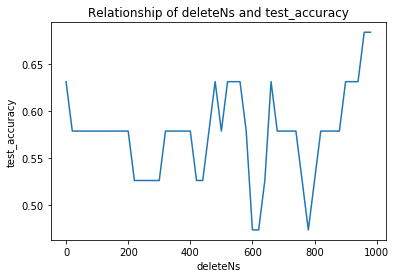

In [5]:
# -*- coding: UTF-8 -*-
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import os
import random
import jieba
%matplotlib inline
"""
函数说明:中文文本处理

Parameters:
    folder_path - 文本存放的路径
    test_size - 测试集占比，默认占所有数据集的百分之20
Returns:
    all_words_list - 按词频降序排序的训练集列表
    train_data_list - 训练集列表
    test_data_list - 测试集列表
    train_class_list - 训练集标签列表
    test_class_list - 测试集标签列表
Author:
    Jack Cui
Blog:
    http://blog.csdn.net/c406495762
Modify:
    2017-08-22
"""
def TextProcessing(folder_path, test_size = 0.2):
    folder_list = os.listdir(folder_path)                        #查看folder_path下的文件
    data_list = []                                                #数据集数据
    class_list = []                                                #数据集类别

    #遍历每个子文件夹
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)        #根据子文件夹，生成新的路径
        files = os.listdir(new_folder_path)                        #存放子文件夹下的txt文件的列表

        j = 1
        #遍历每个txt文件
        for file in files:
            if j > 100:                                            #每类txt样本数最多100个
                break
            with open(os.path.join(new_folder_path, file), 'r', encoding = 'utf-8') as f:    #打开txt文件
                raw = f.read()

            word_cut = jieba.cut(raw, cut_all = False)            #精简模式，返回一个可迭代的generator
            word_list = list(word_cut)                            #generator转换为list

            data_list.append(word_list)                            #添加数据集数据
            class_list.append(folder)                            #添加数据集类别
            j += 1

    data_class_list = list(zip(data_list, class_list))            #zip压缩合并，将数据与标签对应压缩
    random.shuffle(data_class_list)                                #将data_class_list乱序
    index = int(len(data_class_list) * test_size) + 1            #训练集和测试集切分的索引值
    train_list = data_class_list[index:]                        #训练集
    test_list = data_class_list[:index]                            #测试集
    train_data_list, train_class_list = zip(*train_list)        #训练集解压缩
    test_data_list, test_class_list = zip(*test_list)            #测试集解压缩

    all_words_dict = {}                                            #统计训练集词频
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict.keys():
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1

    #根据键的值倒序排序
    all_words_tuple_list = sorted(all_words_dict.items(), key = lambda f:f[1], reverse = True)
    all_words_list, all_words_nums = zip(*all_words_tuple_list)    #解压缩
    all_words_list = list(all_words_list)                        #转换成列表
    return all_words_list, train_data_list, test_data_list, train_class_list, test_class_list

"""
函数说明:读取文件里的内容，并去重

Parameters:
    words_file - 文件路径
Returns:
    words_set - 读取的内容的set集合
Author:
    Jack Cui
Blog:
    http://blog.csdn.net/c406495762
Modify:
    2017-08-22
"""
def MakeWordsSet(words_file):
    words_set = set()                                            #创建set集合
    with open(words_file, 'r', encoding = 'utf-8') as f:        #打开文件
        for line in f.readlines():                                #一行一行读取
            word = line.strip()                                    #去回车
            if len(word) > 0:                                    #有文本，则添加到words_set中
                words_set.add(word)                               
    return words_set                                             #返回处理结果

"""
函数说明:根据feature_words将文本向量化

Parameters:
    train_data_list - 训练集
    test_data_list - 测试集
    feature_words - 特征集
Returns:
    train_feature_list - 训练集向量化列表
    test_feature_list - 测试集向量化列表
Author:
    Jack Cui
Blog:
    http://blog.csdn.net/c406495762
Modify:
    2017-08-22
"""
def TextFeatures(train_data_list, test_data_list, feature_words):
    def text_features(text, feature_words):                        #出现在特征集中，则置1                                               
        text_words = set(text)
        features = [1 if word in text_words else 0 for word in feature_words]
        return features
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    return train_feature_list, test_feature_list                #返回结果


"""
函数说明:文本特征选取

Parameters:
    all_words_list - 训练集所有文本列表
    deleteN - 删除词频最高的deleteN个词
    stopwords_set - 指定的结束语
Returns:
    feature_words - 特征集
Author:
    Jack Cui
Blog:
    http://blog.csdn.net/c406495762
Modify:
    2017-08-22
"""
def words_dict(all_words_list, deleteN, stopwords_set = set()):
    feature_words = []                            #特征列表
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > 1000:                            #feature_words的维度为1000
            break                               
        #如果这个词不是数字，并且不是指定的结束语，并且单词长度大于1小于5，那么这个词就可以作为特征词
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1 < len(all_words_list[t]) < 5:
            feature_words.append(all_words_list[t])
        n += 1
    return feature_words

"""
函数说明:新闻分类器

Parameters:
    train_feature_list - 训练集向量化的特征文本
    test_feature_list - 测试集向量化的特征文本
    train_class_list - 训练集分类标签
    test_class_list - 测试集分类标签
Returns:
    test_accuracy - 分类器精度
Author:
    Jack Cui
Blog:
    http://blog.csdn.net/c406495762
Modify:
    2017-08-22
"""
def TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list):
    classifier = MultinomialNB().fit(train_feature_list, train_class_list)
    test_accuracy = classifier.score(test_feature_list, test_class_list)
    return test_accuracy

if __name__ == '__main__':
    #文本预处理
    folder_path = './SogouC/Sample'                #训练集存放地址
    all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = TextProcessing(folder_path, test_size=0.2)

    # 生成stopwords_set
    stopwords_file = './stopwords_cn.txt'
    stopwords_set = MakeWordsSet(stopwords_file)


    test_accuracy_list = []
    deleteNs = range(0, 1000, 20)                #0 20 40 60 ... 980
    for deleteN in deleteNs:
        feature_words = words_dict(all_words_list, deleteN, stopwords_set)
        train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words)
        test_accuracy = TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list)
        test_accuracy_list.append(test_accuracy)

    plt.figure()
    plt.plot(deleteNs, test_accuracy_list)
    plt.title('Relationship of deleteNs and test_accuracy')
    plt.xlabel('deleteNs')
    plt.ylabel('test_accuracy')
    plt.show()

In [14]:
if __name__ == '__main__':
    #文本预处理
    folder_path = './SogouC/Sample'                #训练集存放地址
    all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = TextProcessing(folder_path, test_size=0.2)

    # 生成stopwords_set
    stopwords_file = './stopwords_cn.txt'
    stopwords_set = MakeWordsSet(stopwords_file)


    test_accuracy_list = []
    feature_words = words_dict(all_words_list, 450, stopwords_set)
    train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words)
    test_accuracy = TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list)
    test_accuracy_list.append(test_accuracy)
    ave = lambda c: sum(c) / len(c)

In [15]:
print(ave(test_accuracy_list))

0.7368421052631579
